In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scroll bar when displaying Folium map
}

<IPython.core.display.Javascript object>

# Plotting weather patterns

The data for this project comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! In particular, you will be asked to use data from the Ann Arbor Michigan location (my home!). and this is stored in the file: `assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:
* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)


In [54]:
#  I'll be using the folium package to render the data into a map in Jupyter.

import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('assets/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

## Step 1
Loading the dataset and transforming the data into Celsius then extracting all of the rows which have minimum or maximum temperatures.


In [20]:
import pandas as pd
df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [ ]:
#transforming the Data_Value column
df['Data_Value'] = df['Data_Value'] / 10
tmax=df[df['Element']=='TMAX']
tmin=df[df['Element']=='TMIN']
del tmax['Element']
del tmin['Element']

In [9]:
tmax.head()

,ID,Date,Data_Value
0,USW00094889,2014-11-12,0.22
2,USC00200032,2008-05-26,2.78
3,USC00205563,2005-11-11,1.39
4,USC00200230,2014-02-27,-1.06
5,USW00014833,2010-10-01,1.94


## Step 2
In order to visualize the data, the plot should have the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But it is also needed to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

In step 1 two Series objects were created with min and max times for the years 2005 through 2015. Now we use Pandas `groupby` to create max and min temperature Series objects across all weather stations for each day of these years, and we can deal with the records for February 29 (the leap year) by dropping them.

In [ ]:
# creating a DataFrame of maximum temperature by date
tmax['Date']=pd.to_datetime(tmax['Date'])
tmax=tmax[~((tmax['Date'].dt.month==2 )&(tmax['Date'].dt.day==29))]
max_df=tmax.groupby(['Date']).max()
max_df=max_df.reset_index()

# creating a DataFrame of minimum temperatures by date
tmin['Date']=pd.to_datetime(tmin['Date'])
tmin=tmin[~((tmin['Date'].dt.month==2 )&(tmin['Date'].dt.day==29))]
min_df=tmin.groupby(['Date']).min()
min_df=min_df.reset_index()


,ID,Data_Value
Date,,
2005-01-01,USC00200032,-5.6
2005-01-02,USC00200032,-5.6
2005-01-03,USC00200032,0.0
2005-01-04,USC00200032,-3.9
2005-01-05,USC00200032,-9.4


## Step 3
Now we can separate out the data for 2015. Then we use the Pandas `groupby` function to find the max and min of the temperature data for each __day of the year__ for the 2005-2014 data.

In [ ]:
# calculating the minimum and maximum values for the day of the year for 2005 through 2014

tmax_2015=max_df[max_df['Date'].dt.year==2015]
tmax_2005_2014=max_df[(max_df['Date'].dt.year>2004) & (max_df['Date'].dt.year<2015)]

tmax_2015['month_day'] = tmax_2015['Date'].dt.strftime('%m-%d')
tmax_2005_2014['month_day'] = tmax_2005_2014['Date'].dt.strftime('%m-%d')

tmax_2005_2014=tmax_2005_2014.groupby(['month_day']).max()

# calculating the minimum and maximum values for the years 2015

tmin_2015=max_df[min_df['Date'].dt.year==2015]
tmin_2005_2014=min_df[(min_df['Date'].dt.year>2004) & (min_df['Date'].dt.year<2015)]

tmin_2015['month_day'] = tmin_2015['Date'].dt.strftime('%m-%d')
tmin_2005_2014['month_day'] = tmin_2005_2014['Date'].dt.strftime('%m-%d')

tmin_2005_2014=tmin_2005_2014.groupby(['month_day']).max()

tmin_2005_2014=tmin_2005_2014.reset_index()
tmax_2005_2014=tmax_2005_2014.reset_index()
tmin_2015.reset_index(drop=True, inplace=True)
tmax_2015.reset_index(drop=True, inplace=True)

## Step 4
Now it's time to plot! We plot line graphs of the min and max temperatures for the years 2005 through 2014 and do scatter plot __only__ when the daily 2015 temperatures exceeded those values.

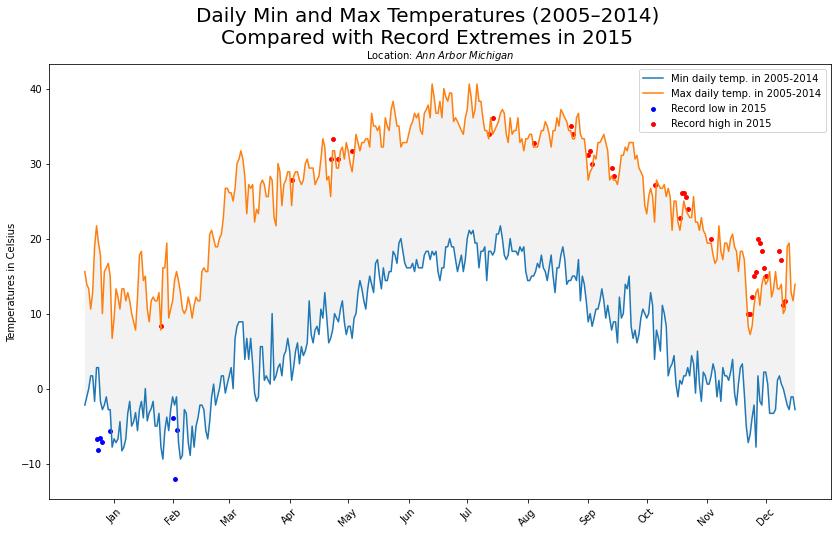

In [ ]:
import matplotlib.pyplot as plt
from calendar import month_abbr

record_high_2015 = tmax_2015[tmax_2015['Data_Value']> tmax_2005_2014['Data_Value']]
record_low_2015 = tmin_2015[tmin_2015['Data_Value'] < tmin_2005_2014['Data_Value']]


plt.figure(figsize=(14,8))


plt.plot(tmin_2005_2014['Data_Value'], '-', label='Min daily temp. in 2005-2014')
plt.plot(tmax_2005_2014['Data_Value'], '-', label='Max daily temp. in 2005-2014')


plt.ylabel('Temperatures in Celsius')
plt.suptitle('Daily Min and Max Temperatures (2005–2014)\nCompared with Record Extremes in 2015', fontsize=20)
plt.title('Location: $Ann$ $Arbor$ $Michigan$',fontsize=10)

month_middles = [15, 45, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.xticks(month_middles, month_names, rotation=45)

plt.gca().fill_between(range(len(tmin_2005_2014['Data_Value'])),
                       tmin_2005_2014['Data_Value'], tmax_2005_2014['Data_Value'],
                       facecolor='grey',
                       alpha=0.1)

plt.scatter(record_low_2015.index,
            record_low_2015['Data_Value'],
            color='blue', s=15, label='Record low in 2015')


plt.scatter(record_high_2015.index,
            record_high_2015['Data_Value'],
            color='red', s=15, label='Record high in 2015')

plt.legend()
plt.savefig('Temp_2005_2015.png')
